In [3]:
#convert the longitudinal blood pressure measurements into a proper time series

import pandas as pd

long_data = pd.read_csv('patient_longitudinal.csv', sep='\t')
long_data['visit_date'] = pd.to_datetime(long_data['visit_date'], format='%Y-%m-%d')

#check for duplicates and remove them and average them 
long_data = long_data.groupby(['patient_id', 'visit_date']).mean().reset_index()

#set visit_data as index 
long_data.set_index('visit_date', inplace=True)

#check for missing values
long_data.isnull().sum()

long_data


,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2023-01-17,0,111.0,78.7,0.0,57.5,0.0,25.8,0.0,0.0
2023-09-23,0,112.0,79.5,0.0,57.5,0.0,25.8,0.0,0.0
2024-05-22,0,111.2,78.7,0.0,57.5,0.0,25.8,0.0,0.0
2024-12-31,0,109.2,79.5,0.0,57.5,0.0,25.8,0.0,0.0
2023-01-17,1,146.1,78.9,0.0,47.9,0.0,23.2,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-12-31,998,136.9,77.1,0.0,41.4,0.0,24.2,0.0,0.0
2023-01-17,999,140.5,96.6,1.0,58.6,0.0,25.6,0.0,0.0
2023-09-23,999,140.2,98.6,0.0,58.6,0.0,25.6,0.0,0.0


In this first part of the problem, i loaded the patient_longitudinal dataset and then added a seperate column named visit_date. I then checked for duplicates and saw that we have 3000 duplicates. I then used aggregation by patient_id calculating the mean numeric columns. I then set the visit_date column as index for time series analysis. I also checked for missing values but there were none. 

/tmp/ipykernel_34382/2470318873.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bp = long_data['bp_systolic'].resample('M').mean()


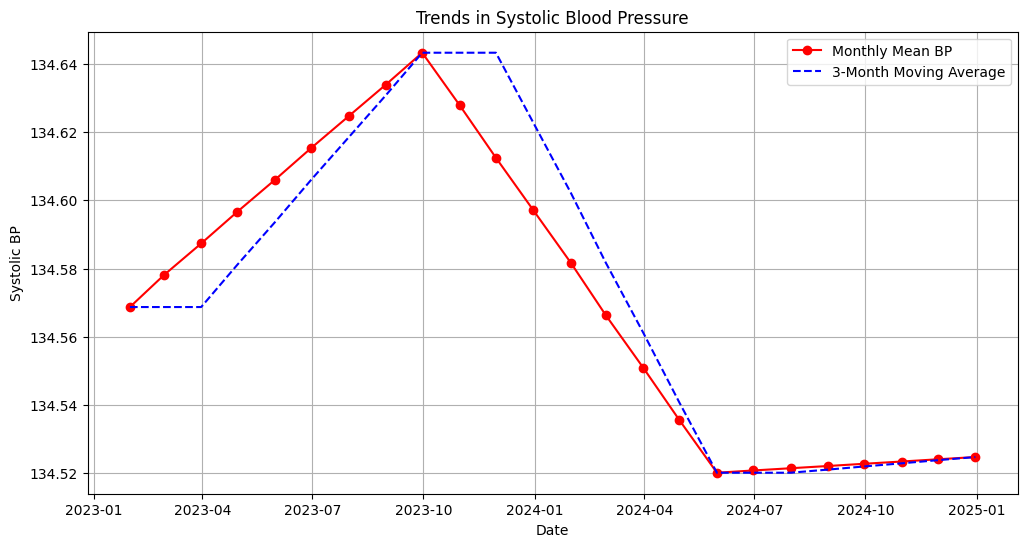

In [4]:
#analyze blood pressure trends 

import matplotlib.pyplot as plt

#month-end frequency 
monthly_bp = long_data['bp_systolic'].resample('M').mean()

#calculate the 3 month moving average
monthly_moving_avg = monthly_bp.rolling(window=3, min_periods=1).mean()

#fill the gaps
monthly_bp = monthly_bp.interpolate()
monthly_moving_avg = monthly_moving_avg.interpolate()

plt.figure(figsize=(12, 6))
plt.plot(monthly_bp, label='Monthly Mean BP', color='red', marker='o', linestyle='-')
plt.plot(monthly_moving_avg, label='3-Month Moving Average', color='blue', linestyle='--')
plt.title('Trends in Systolic Blood Pressure')
plt.xlabel('Date')
plt.ylabel('Systolic BP')
plt.legend()
plt.grid()
plt.show()

The goal for this problem was to analyze blood pressure trends. So to resample the data to month-end frequency and found the monthly mean blood pressure. I then calculated the 3 month moving average to smooth out short term flunctuations. I used interpolate() to fill any gaps in case of missing values. I then plotted it. I used two different colors one for the Monthly mean BP and one for the 3 month moving average. 

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     514.3
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:50:17   Log-Likelihood:                -15095.
No. Observations:                4000   AIC:                         3.020e+04
Df Residuals:                    3995   BIC:                         3.023e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.0140      1.074    100.607      0.0

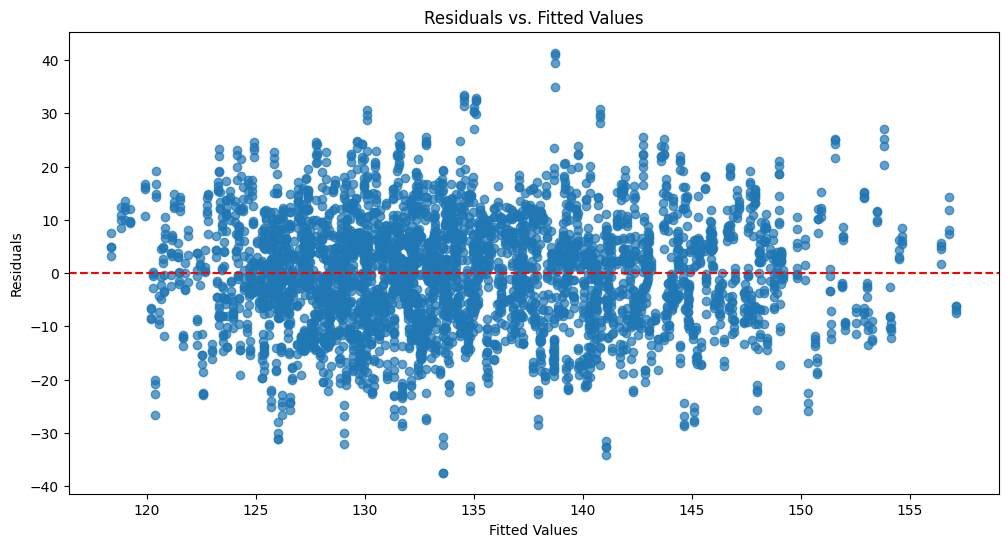

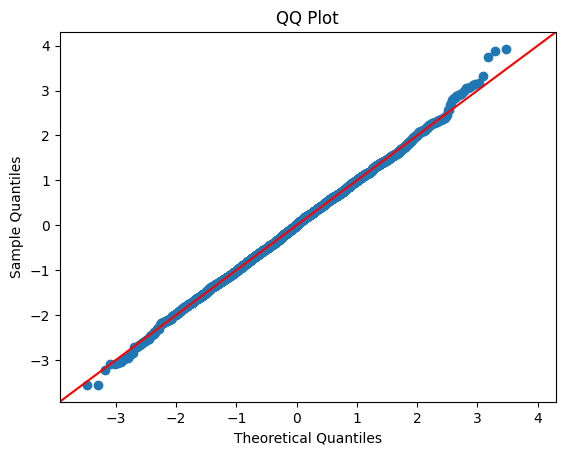

                            OLS Regression Results                            
Dep. Variable:            bp_systolic   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     525.9
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:50:17   Log-Likelihood:                -15095.
No. Observations:                4000   AIC:                         3.020e+04
Df Residuals:                    3995   BIC:                         3.023e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.0140      1.073    100.712      0.0

In [13]:
#analyze factors affecting baseline BP
import statsmodels.api as sm 

#we have our x variables (age, bmi, smoking, diabetes) and outcome which is BP
y = long_data['bp_systolic']  
X = long_data[['age', 'bmi', 'smoking', 'diabetes']]  

#Add intercept column to X
X = sm.add_constant(X)

#fit the model
model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

#plot residuals vs fitted vlaues 
fitted_values = results.fittedvalues
residuals = results.resid
plt.figure(figsize=(12, 6))
plt.scatter(fitted_values, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

#QQ Plot 
sm.qqplot(residuals, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

#consider robust SE with HC3
model_robust = sm.OLS(y, X).fit(cov_type='HC3')
print(model_robust.summary())


Let's first interpret the regression output when we fit the model. Our R2 is 0.340 which means that about 34% of the variability in our outcome (BP) is explained by the model's predcitors. This implies a good fit but there is a good chance that other factors that is not includes that may influence BP. Let's look at our coefficients. Our constant is 108.014 so this is the vlaue when all our predicted vaiables are zero. First is Age, which is 0.2854 so every year of age that is added BP is predicted to increase by 0.285 mmHg assuming all other variables are held constant. This is a positive relationship between age and BP. For BMI, each unit increase in BMI is associated with an increase of 0.2985 mmHg in BP. So the higher the BMI the higher the BP. Being a smoker is associated with a 5.045 mmHg increase in BP. This was one of the biggest coefficient highliting a strong association. Another big one was diabetes. People with diabetes have a 9.629 mmHg increase in BP than those who dont have diabetes. All the predictors had a p value less than 0.001 meaning their effect on BP is satisitically significant. So in other words the predictors age, BMI, smoking, and diabetes all signficantly affect BP with diabetes with the strongest association. 

If we look at our graphs, such as the residuals vs fitted values we can see that there is linearity. The residuals are scattered symmetrically around the zero line which indicates that the relationship between the predictors and outcome variable are linear. It also shows homoscedasticity thus the variance of the residuals is constant. This means that our model fits the data well. Now for the QQ plot we can see how the dots follow the striaght line. This means that the normality assumption is met so the residuals are likley to be normally distributed. There is little deviation at the top but for the most part there is none. 

With the robust SE using HC3, we see that smoking has a robust SE of 0.371 and for diabetes the robust SE is 0.396. The p values are all 0 so that means the predictor is statsitically significant in predicting BP.

In [ ]:
#model treatment effectiveness 
import numpy as np

treat_data = pd.read_csv('patient_treatment.csv', sep='\t')
y = treat_data['outcome'] 
X = treat_data[['treatment', 'age', 'bmi', 'smoking', 'diabetes', 'adherence']]  
X = sm.add_constant(X)
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

odds_ratios = np.exp(model.params)

conf_intervals = model.conf_int()

influence = model.get_influence()
cooks_d = influence.cooks_distance
cooks_d_values = cooks_d[0] 
influential_points = np.where(cooks_d_values > 1)[0] 

print("Influential Observations (Cook's Distance > 1):", influential_points)
print("Confidence Intervals:\n", conf_intervals)
print("Odds Ratios:\n", odds_ratios)
print("Residual Deviance:", model.deviance)
print("Null Deviance:", model.null_deviance)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      993
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -601.75
Date:                Mon, 04 Nov 2024   Deviance:                       1203.5
Time:                        22:29:11   Pearson chi2:                     997.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1230
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3329      0.720     -3.242      0.0

In [27]:
print("Residual Deviance:", model.deviance)
print("Null Deviance:", model.null_deviance)

Residual Deviance: 1203.5088609575953
Null Deviance: 1334.774434101428


Let's look at our summary table first. Our intercept is -2.3329 which represents the log odds of the outcome when all predictors are 0. The treatment coefficient is 1.4239 which means treatment increases the chances of succesful outcome. Age was -0.0004 which means a very small negative effect and its also not statsitically significant sicne the p value is 0.942. BMI is similar to add and not signficiant. Smoking has a coefficient of -0.4244 which means smoking decreases the chances of a succesful outcome and its significant. Diabetes as well. Adherence has a coefficient of 1.9230 so a higher adherence the higher the chance of succesful outcome. 

Let's look at our influence points. I used cooks distance to see if there is any points that are influential and there is none! This is a good sign because this means our model is stable. 

Now for the confidence intervals, let's do treatment first its (1.20, 1.728) so this indicates that treatment is positively associated with the outcome. The bounds are over 1 we can infer that the treatment increases the odds of success. Let's do age, (-0.010, 0.010) so this CI includes zero meaning its not that significant to the outcome. Same thing for BMI. Smoking on the other hand, (-0.841, -0.008), this interval does not include 0 and its negative so smoking decreases the odds of treatment success which makes sense. Same thing for diabetes. Adherence is (0.540, 3.306) so this interval is above 1 which means the higher the adherence the higher the odds of treatment success. 

Let's do odds ratio. For treatment its 4.153 so getting treatment increases the odds of success by 4.15 times more compared to not receiving it. This means that treatment is highly effective. For age is 0.9996 and since its close to 1 it has no effect on treatment success. Same thing for BMI. For smoking its 0.654 so smokers have a 35% lower odds of treatment success compared to non smokers thus a negative association. This is similar to diabetes. Then for adherence its 6.841 so high adherence to treatment is associated with a better outcome. 

Our null deviance is 1334.77 and residual deviance is 1203.51. We see that the null deviance is higher than the residual deviance meaning that our predictors explain a good amount of variance in the outcome. 

With that being said, we can see that the treatment and adherence are the most significant factors that influences a successful treatment success while smoking and diabetes decrease the success. 